## Семинар 4: "Сверточные сети"

ФИО: 

In [1]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [6]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    for i in range(signal.shape[0]-kernel.shape[0]+1):
        signal_convolved[i] = np.sum(signal[i : i + kernel.shape[0]] * kernel[::-1])
    return signal_convolved

In [ ]:
from scipy.signal import convolve

Проверим правильность реализации, сравнив с реализацией из scipy

In [8]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

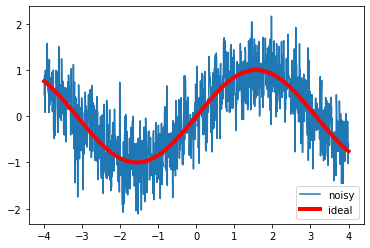

In [9]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [10]:
kernel_size = 5
kernel = np.ones(kernel_size)/kernel_size#YOUR CODE HERE
denoised_signal = convolve(noisy_signal, kernel, 'same')

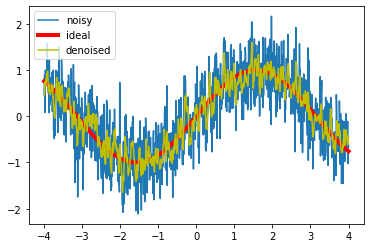

In [11]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [14]:
### YOUR CODE HERE #####
best_kernel_size = None
min_error = None
for kernel_size in range(1, 2000):
    kernel = np.ones(kernel_size)/kernel_size#YOUR CODE HERE
    denoised_signal = convolve(noisy_signal, kernel, 'same')
    
    mse = ((denoised_signal - signal)**2).mean()
    if min_error is None or mse < min_error:
        min_error = mse
        best_kernel_size = kernel_size
best_kernel_size

57

In [19]:
kernel_size = 1000
kernel = np.ones(kernel_size)/kernel_size#YOUR CODE HERE
denoised_signal = convolve(noisy_signal, kernel, 'same')

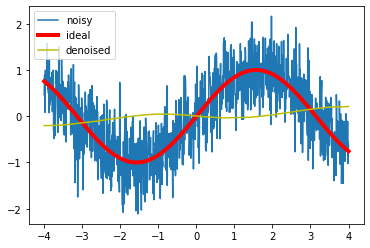

In [20]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

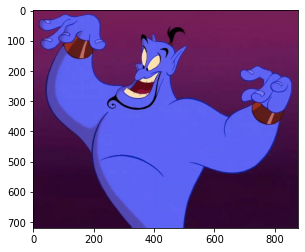

In [22]:
image = plt.imread('./Genie.jpg')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [35]:
color_to_bw_simple = np.array([1/3, 1/3, 1/3])#### YOUR CODE HERE #####
color_to_bw = np.array([0.2125, 0.7154, 0.0721])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

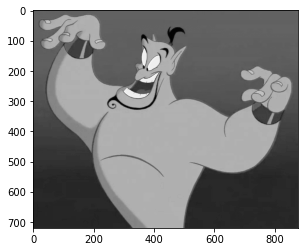

In [37]:
from scipy.signal import convolve2d

bw_image = convolve(image.flatten(), color_to_bw_simple, "same")[::3].reshape(image.shape[:-1])##### YOUR CODE HERE #####
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

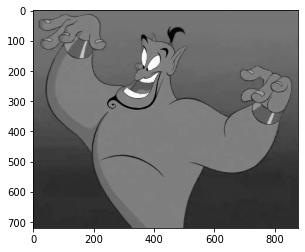

In [38]:
from scipy.signal import convolve2d

bw_image = convolve(image.flatten(), color_to_bw, "same")[::3].reshape(image.shape[:-1])##### YOUR CODE HERE #####
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

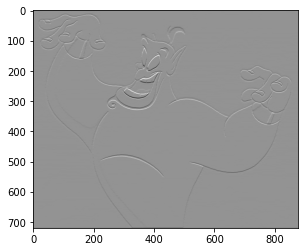

In [39]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

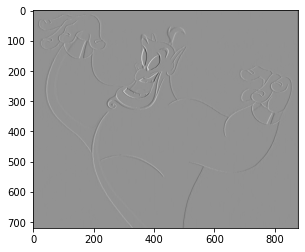

In [40]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

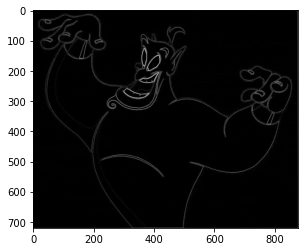

In [42]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [44]:
#signal - n x m x c
#kernel - c x 1 x 1 x d
#signal_out - n x m x d

def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    assert signal.shape[-1] == kernel.shape[0]
    ##### YOUR CODE HERE #####
    
    signal_out = np.zeros(signal.shape[:-1] + (kernel.shape[-1],))
    
    for j in range(kernel.shape[0]):
        for k in range(kernel.shape[-1]):
            signal_out[:,:,k] += convolve2d(signal[:, :, j], kernel[j, :, :, k], "same")

    return signal_out

In [48]:
def t_convolve_bank_naive(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    assert signal.shape[-1] == kernel.shape[0]
    ##### YOUR CODE HERE #####
    
    signal_out = np.zeros(signal.shape[:-1] + (kernel.shape[-1],))
    
    for i in range(signal.shape[0]- kernel.shape[1]):
        for j in range(signal.shape[1] - kernel.shape[2]):
            for k in range(kernel.shape[-1]):
                signal_out[i, j, k] = np.sum(signal[i:i+kernel.shape[1], j:j+kernel.shape[2]] * kernel[:,:,:,k].transpose(1,2,0))

    return signal_out

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

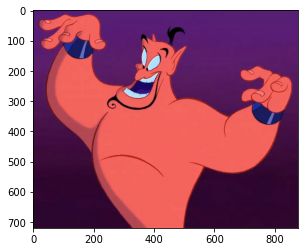

In [47]:
##### YOUR CODE HERE #####

convert_kernel = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
]).reshape(3, 1, 1, 3)

convert_kernel_bgr = t_convolve_bank(image, convert_kernel)
plt.imshow(convert_kernel_bgr.astype('uint8'))

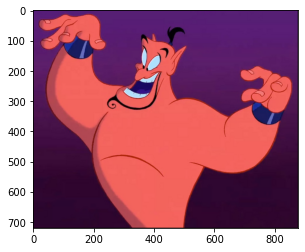

In [49]:
##### YOUR CODE HERE #####

convert_kernel = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
]).reshape(3, 1, 1, 3)

convert_kernel_bgr = t_convolve_bank_naive(image, convert_kernel)
plt.imshow(convert_kernel_bgr.astype('uint8'))

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

In [ ]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [71]:
def pooling(image, w=2, func=np.max):

    image_out = np.zeros((image.shape[0]//w, image.shape[1]//w, image.shape[2]))
    
    for i in range(0, image.shape[0]-w, w):
        for j in range(0, image.shape[1]-w, w):
            image_out[i//w, j//w, :] = func(image[i : i + w, j : j + w, :], axis = (0, 1))
            
    return image_out

def maxpool(image, w=2):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    pooling(image, w, np.max)

def medianpool(image, w=2):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    pooling(image, w, np.median)


Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

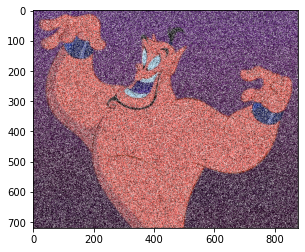

In [60]:
##### YOUR CODE HERE #####

noised_image = convert_kernel_bgr.copy()

p = 0.7

noised_image[np.random.randn(noised_image.shape[0], noised_image.shape[1]) > p] = (0, 0, 0)
noised_image[np.random.randn(noised_image.shape[0], noised_image.shape[1]) > p] = (255, 255, 255)

plt.imshow(noised_image.astype('uint8'))

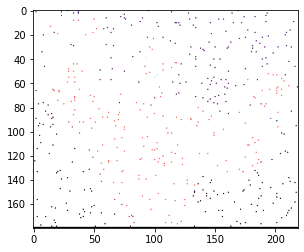

In [75]:
denoised_image = pooling(noised_image, w=4, func=np.max)
plt.imshow(denoised_image.astype('uint8'))

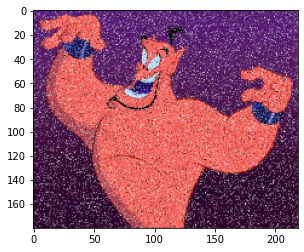

In [69]:
denoised_image = pooling(denoised_image, w=2, func=np.median)
plt.imshow(denoised_image.astype('uint8'))

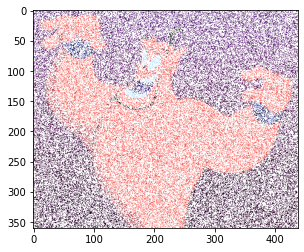

In [67]:
denoised_image = pooling(noised_image, w=2, func=np.max)
plt.imshow(denoised_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [76]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [102]:
# пример сверточной сети

#in_channels, out_channels, kernel_size

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(2, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        #self.conv2 = nn.Sequential(nn.Conv2d(8, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//4*image_size//4*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear_layers(x)
        return x

In [94]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.173/0.149	Accuracy: 0.948/0.957


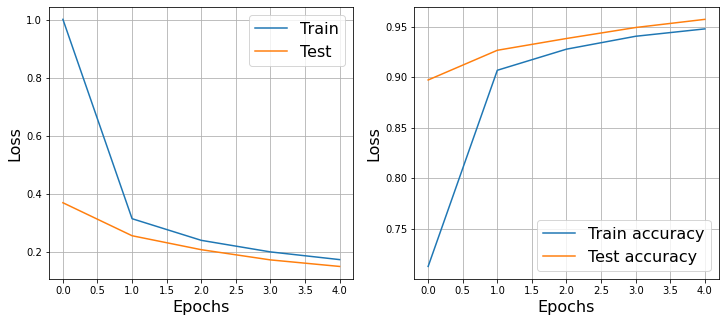

In [99]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

In [103]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

RuntimeError: Given groups=1, weight of size [8, 2, 3, 3], expected input[32, 1, 28, 28] to have 2 channels, but got 1 channels instead

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [82]:
##### YOUR CODE HERE #####
n=0
for p in network.parameters():
    n += p.numel()
n

5920

In [100]:
##### YOUR CODE HERE #####
n=0
for p in network.parameters():
    n += p.numel()
n

1779

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batc

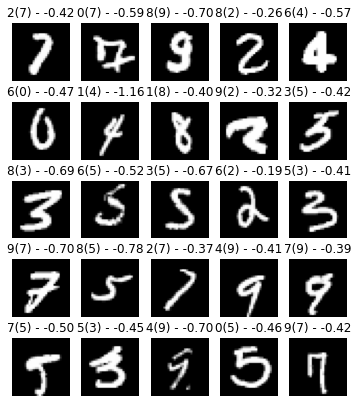

In [87]:
##### YOUR CODE HERE #####

bank = []

for img, target in test_loader:
    y = network(img)
    y_pred = y.detach().argmax(-1)
    print('Batch')
    for i in range(img.shape[0]):
        if target[i] != y_pred[i]:
            bank.append((img[i].reshape(28, 28), "{}({}) - {:.2f}".format(y_pred[i], target[i], y[i][y_pred[i]].detach().numpy())))


plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(bank[i][0], cmap=plt.cm.Greys_r)
    plt.title(bank[i][1])
    plt.axis('off')

Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batch
Batc

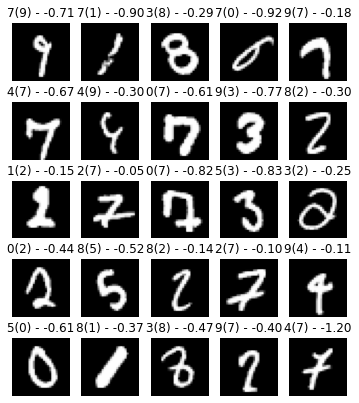

In [101]:
##### YOUR CODE HERE #####

bank = []

for img, target in test_loader:
    y = network(img)
    y_pred = y.detach().argmax(-1)
    print('Batch')
    for i in range(img.shape[0]):
        if target[i] != y_pred[i]:
            bank.append((img[i].reshape(28, 28), "{}({}) - {:.2f}".format(y_pred[i], target[i], y[i][y_pred[i]].detach().numpy())))


plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(bank[i][0], cmap=plt.cm.Greys_r)
    plt.title(bank[i][1])
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [ ]:
##### YOUR CODE HERE #####

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: